In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

2023-12-08 14:00:36.954234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 14:00:36.954258: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 14:00:36.954282: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 14:00:36.960300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 14:00:37.727846: W tensorflow/compiler/

In [2]:
# Load and preprocess CIFAR-10 data
(train_images_x, train_labels_y), (test_images_x, test_labels_y) = cifar10.load_data()
train_images = tf.keras.applications.vgg16.preprocess_input(train_images_x)
test_images = tf.keras.applications.vgg16.preprocess_input(test_images_x)
train_labels = to_categorical(train_labels_y)
test_labels = to_categorical(test_labels_y)

# Inspect VGG16 base model
VGG16 with and without its fully connected layers

In [3]:
vgg_base_model_with_top = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

2023-12-08 14:00:39.533814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 14:00:39.563158: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
vgg_base_model_with_top.layers

In [5]:
vgg_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [6]:
vgg_base_model.layers

# VGG16 feature extraction

In [7]:
# Load pre-trained VGG16 model without the top layer
def create_vgg_feature_extraction_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    # Freeze the base model
    base_model.trainable = False
    
    # Create a new model on top
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(10, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
model = create_vgg_feature_extraction_model()

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 14719928 (56.15 MB)
Trainable params: 5240 (20.47 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [10]:
def show_images(images, labels, num_rows=2, num_cols=2, scale=2):
    """Display a grid of images with labels."""
    _, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*scale, num_rows*scale))
    axs = axs.flatten()
    for img, ax, label in zip(images, axs, labels):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('Label: ' + str(label))
    plt.show()

In [11]:
subset_images = train_images_x[16:20]
subset_labels = train_labels_y[16:20]

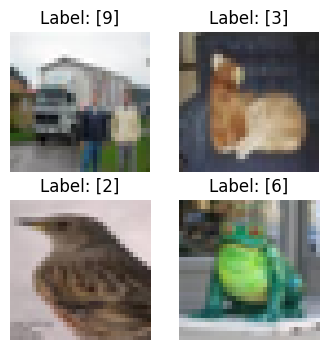

In [12]:
show_images(subset_images, subset_labels)

# Tasks
- Experiement with different setups of fully connected layers

# Finetune VGG16

In [16]:
def create_vgg_finetuning_model():
    # Load pre-trained VGG16 model without the top layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Fine-tune from this layer onwards
    fine_tune_at = 2

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Create a new model on top
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(10, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs, outputs)

    # It's important to recompile the model after making any changes
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [17]:
model = create_vgg_finetuning_model()

In [18]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                5130      
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
Total params: 14719928 (56.15 MB)
Trainable params: 14718136 (56.15 MB)
Non-trainable params: 1792 (7.00 KB)
_________________________________________________________________


# Task
- Experiment with different amount of layers to finetune
  - Does it effect the training time?
- Experiment with different fully connected layers